# シンプルなFC層を用いたモデル

### 方針

・条件付き確率（遷移確率）と尤度の和から次の尤度を求める

### データの生成

・データの用意

In [1]:
import numpy as np

# 問題の依存関係の行列 A 
A = np.array([
    [0, 0, 0, 0, 0],  # 初期状態
    [1, 0, 0, 0, 0],  # 問題1は初期状態のみに依存
    [0, 1, 0, 0, 0],  # 問題2は問題1に依存
    [0, 0, 1, 0, 0],  # 問題3は問題2に依存
    [0, 0, 1, 1, 0]   # 問題4は問題2、問題3に依存
])


# 遷移確率を計算する関数（そのまま使用）
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 不正解の問題のみ計算
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            # # 依存関係がすべて0であるかを確認
            # if np.all(required_problems == 0):
            #     raw_probabilities[i] =  10  # 必要なら、この問題の遷移確率を設定
            #     continue
            
            solved_problems = X * required_problems  # 実際に解けた問題
            
            num_required = np.sum(required_problems)  # 必要な問題の数
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            if num_required > 0:
                raw_probabilities[i] = np.exp(num_solved / num_required)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

In [2]:
# 教師データセットを生成する関数
def generate_training_data(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数
    dataset = []
    
    # 各ステップでデータを生成
    for i in range(1, num_correct_problems + 1):  # 1問以上の正解を対象にする
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            
            # i問正解させる
            for k in range(i):
                input_X = X.copy()    # 遷移前状態を保持
                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
            
                # 初期状態と1ステップ後の状態の差分を教師データとして使用
                target_Y = (X - input_X).clip(min=0)  # 0から1に変わった部分のみを1、他は0
                
                # 初期状態（入力）と差分（教師データ）のペアを保存
                dataset.append((input_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
    
    return dataset


In [3]:
# データセット生成
num_correct_problems = 4  # 初期状態から4問まで正解
num_data_per_step = 10000     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([1, 0, 0, 0, 0])

dataset = generate_training_data(A, X_init, num_correct_problems, num_data_per_step)

# 結果を表示
print("生成されたデータセット:")
print(dataset)

生成されたデータセット:
[(array([1, 0, 0, 0, 0]), array([0, 0, 0, 1, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 1, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 1, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 1, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0, 1, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0, 0, 0, 1])), (array([1, 0, 0, 0, 0]), array([0, 0

In [4]:
import itertools
from collections import defaultdict

num_questions = 4

# Generate states where the first digit is always 1
states = [(1,) + state for state in itertools.product([0, 1], repeat=num_questions)]
print(f"Number of States: {len(states)}\n")

# Initialize the state counts
state_counts = defaultdict(int)

# Assuming 'dataset' is your list of student results
for result, _ in dataset:
    state_tuple = tuple(map(int, result))  # Convert np.int64 to int
    if state_tuple[0] == 1:
        state_counts[state_tuple] += 1  # Count only if the first digit is 1

# Display the counts for each state
for state in states:
    count = state_counts[state]
    formatted_state = list(state)  # Convert tuple to list for the desired format
    print(f"State {formatted_state}: {count} students")

print(dataset[35998])
print(state_counts)

Number of States: 16

State [1, 0, 0, 0, 0]: 40000 students
State [1, 0, 0, 0, 1]: 5403 students
State [1, 0, 0, 1, 0]: 5264 students
State [1, 0, 0, 1, 1]: 1910 students
State [1, 0, 1, 0, 0]: 5161 students
State [1, 0, 1, 0, 1]: 1555 students
State [1, 0, 1, 1, 0]: 2045 students
State [1, 0, 1, 1, 1]: 1159 students
State [1, 1, 0, 0, 0]: 14172 students
State [1, 1, 0, 0, 1]: 4005 students
State [1, 1, 0, 1, 0]: 3824 students
State [1, 1, 0, 1, 1]: 1923 students
State [1, 1, 1, 0, 0]: 6661 students
State [1, 1, 1, 0, 1]: 3054 students
State [1, 1, 1, 1, 0]: 3864 students
State [1, 1, 1, 1, 1]: 0 students
(array([1, 1, 0, 0, 0]), array([0, 0, 0, 1, 0]))
defaultdict(<class 'int'>, {(1, 0, 0, 0, 0): 40000, (1, 1, 0, 0, 0): 14172, (1, 0, 0, 1, 0): 5264, (1, 0, 1, 0, 0): 5161, (1, 0, 0, 0, 1): 5403, (1, 1, 0, 0, 1): 4005, (1, 0, 1, 0, 1): 1555, (1, 0, 0, 1, 1): 1910, (1, 1, 1, 0, 0): 6661, (1, 1, 0, 1, 0): 3824, (1, 0, 1, 1, 0): 2045, (1, 1, 1, 1, 0): 3864, (1, 1, 1, 0, 1): 3054, (1, 1, 0,

In [5]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# # グラフの作成
# G = nx.Graph()

# # ノードの追加
# for state in states:
#     G.add_node(state, count=state_counts[state])

# # エッジの追加
# for state in states:
#     for i in range(num_questions):
#         next_state = list(state)
#         if next_state[i] == 0:
#             next_state[i] = 1
#             G.add_edge(state, tuple(next_state))

# # カスタムレイアウト関数
# def custom_layout(G, num_questions):
#     pos = {}
#     for state in G.nodes():
#         level = sum(state)
#         # 各レベルでのノードの数を数える
#         level_count = sum(1 for node in G.nodes() if sum(node) == level)
#         # このレベルでの現在のノードの位置を計算
#         level_position = sum(state[i] * 2**(num_questions-i-1) for i in range(num_questions))
#         x = level_position / (2**num_questions - 1)  # x座標を0~1の範囲に正規化
#         y = level / num_questions  # y座標を0~1の範囲に正規化
#         pos[state] = (x, y)
#     return pos

# # カスタムレイアウトの適用
# pos = custom_layout(G, num_questions)

# # プロットの設定
# plt.figure(figsize=(18, 6))  # 縦長に変更

# # エッジの描画
# nx.draw_networkx_edges(G, pos, alpha=0.2)

# # ノードの描画
# node_sizes = [max(300, min(3000, G.nodes[node]['count'] * 50)) for node in G.nodes()]
# node_colors = [G.nodes[node]['count'] for node in G.nodes()]
# nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd)

# # ノードのラベル描画
# nx.draw_networkx_labels(G, pos, {node: ''.join(map(str, node)) for node in G.nodes()}, font_size=8)

# # カラーバーの追加
# plt.colorbar(nodes, label='Number of Students')

# plt.title('Vertical Network Graph of Test Results')
# plt.axis('off')
# plt.tight_layout()

# # グラフの表示
# plt.show()

# # 各状態の学生数を表示
# for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
#     print(f"State {''.join(map(str, state))}: {count} students")

## モデル

### FCモデル

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class Model(nn.Module):
    def __init__(self, num_questions):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_questions, num_questions)  # 全結合層

    def forward(self, x):
        x = self.fc(x)  # 全結合層の適用
        x = F.softmax(x, dim=1)  # ソフトマックスを適用
        return x

In [7]:
# データセットの生成
num_correct_problems = 5  # 初期状態から4問まで正解
num_data_per_step = 1000     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([1, 0, 0, 0, 0])

training_data = generate_training_data(A, X_init, num_correct_problems, num_data_per_step)

# PyTorch テンソルに変換
train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)
train_Y = torch.tensor([target_data for _, target_data in training_data], dtype=torch.float32)

# モデル、損失関数、最適化関数の設定
model = Model(num_correct_problems)  # 5問の問題を扱うモデル
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)  # L2正則化

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_31608/2253889786.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)


In [8]:
# 学習ループ
num_epochs = 10000  # エポック数
for epoch in range(num_epochs):
    model.train()  # モデルを訓練モードに
    optimizer.zero_grad()  # 勾配の初期化
    
    # モデルの予測
    outputs = model(train_X)
    
    # 損失の計算
    loss = criterion(outputs, train_Y)
    
    # バックプロパゲーションとパラメータの更新
    loss.backward()
    optimizer.step()
    
    # 100エポックごとに損失を表示
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 学習結果の確認
print("Training complete!")

Epoch [500/10000], Loss: 1.2372
Epoch [1000/10000], Loss: 1.2340
Epoch [1500/10000], Loss: 1.2337
Epoch [2000/10000], Loss: 1.2337
Epoch [2500/10000], Loss: 1.2337
Epoch [3000/10000], Loss: 1.2337
Epoch [3500/10000], Loss: 1.2337
Epoch [4000/10000], Loss: 1.2337
Epoch [4500/10000], Loss: 1.2337
Epoch [5000/10000], Loss: 1.2337
Epoch [5500/10000], Loss: 1.2337
Epoch [6000/10000], Loss: 1.2337
Epoch [6500/10000], Loss: 1.2337
Epoch [7000/10000], Loss: 1.2337
Epoch [7500/10000], Loss: 1.2337
Epoch [8000/10000], Loss: 1.2337
Epoch [8500/10000], Loss: 1.2337
Epoch [9000/10000], Loss: 1.2337
Epoch [9500/10000], Loss: 1.2337
Epoch [10000/10000], Loss: 1.2337
Training complete!


## テスト

In [9]:
test = np.array([[1, 1, 0, 1, 0]])

# numpy配列をtorch.Tensorに変換
test_tensor = torch.tensor(test, dtype=torch.float32)

# モデルに入力を渡して出力を得る
output = model(test_tensor)
print("Output:", output)

Output: tensor([[0.0020, 0.0210, 0.7967, 0.0037, 0.1767]], grad_fn=<SoftmaxBackward0>)


In [10]:
# モデルの各パラメータを表示
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-1.0443, -0.4094, -0.2791, -0.1965, -0.1777],
        [ 1.5121, -3.6684, -0.5644,  0.3132,  0.7008],
        [ 0.1636,  2.6859, -3.2682,  0.2926,  0.5484],
        [-0.2073,  0.6709,  2.4566, -2.3362,  0.7997],
        [-0.4241,  0.7211,  1.6550,  1.9268, -1.8712]], requires_grad=True)
Parameter containing:
tensor([-1.0443,  1.5121,  0.1636, -0.2073, -0.4241], requires_grad=True)


・図示

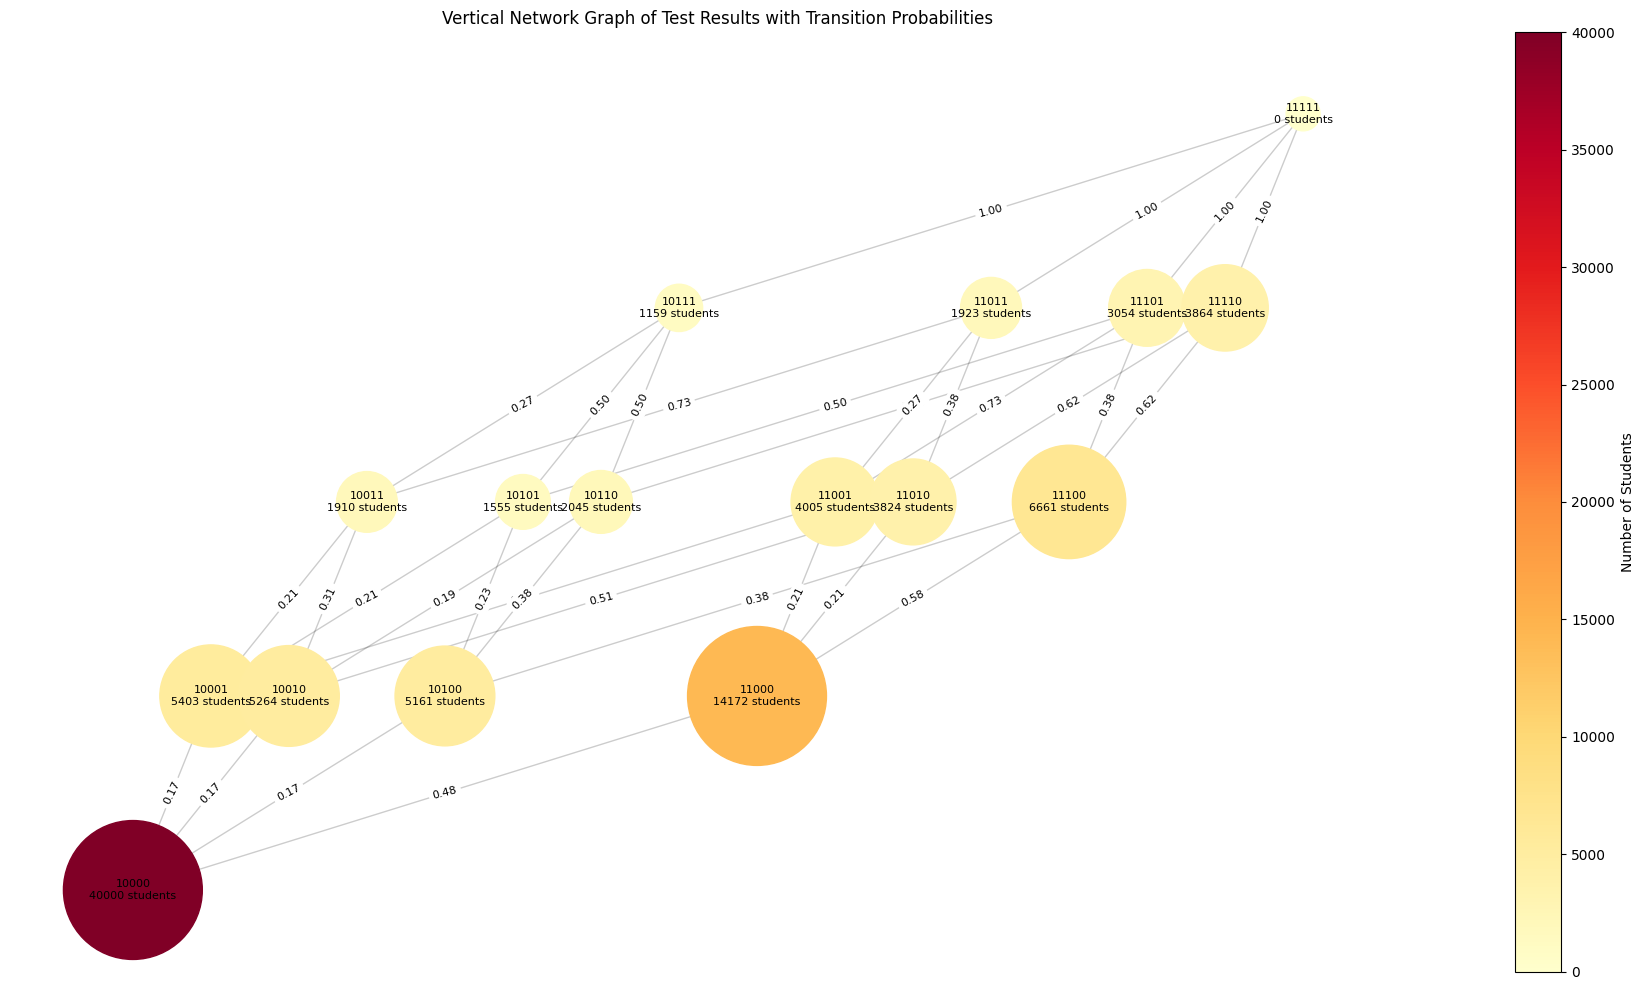

State counts:
State 10000: 40000 students
State 11000: 14172 students
State 10010: 5264 students
State 10100: 5161 students
State 10001: 5403 students
State 11001: 4005 students
State 10101: 1555 students
State 10011: 1910 students
State 11100: 6661 students
State 11010: 3824 students
State 10110: 2045 students
State 11110: 3864 students
State 11101: 3054 students
State 11011: 1923 students
State 10111: 1159 students
State 11111: 0 students


In [19]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with inverted y-axis and central alignment
def custom_layout(G, num_questions):
    pos = {}
    max_level = num_questions + 1  # Maximum number of ones possible
    for state in G.nodes():
        level = sum(state)
        # Each level's nodes are placed horizontally
        x = sum(state[i] * 2**(num_questions - i) for i in range(num_questions + 1))
        y = level  # Inverted y: make sure y increases upwards
        pos[state] = (x, y)
    
    # Normalize and center the layout (both x and y)
    x_values = [p[0] for p in pos.values()]
    y_values = [p[1] for p in pos.values()]
    
    # Calculate the center offsets
    x_center_offset = (max(x_values) + min(x_values)) / 2
    y_center_offset = (max(y_values) + min(y_values)) / 2
    
    # Adjust positions so the graph is centered
    for node in pos:
        x, y = pos[node]
        pos[node] = (x - x_center_offset, y - y_center_offset)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_questions)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(600, min(3000, count * 500))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

# Transition probabilities: add labels to edges
edge_labels = {}
for state in states:
    probabilities = calculate_transition_probabilities(A, np.array(state))
    print(state)
    print(probabilities)
    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                edge_labels[(state, next_state)] = f"{probabilities[i]:.2f}"

# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")

### 学習

### テスト